In [76]:
#adapted from https://www.machinalis.com/blog/python-for-geospatial-data-processing/
import numpy as np
import fiona
import geopandas as gpd
import pandas as pd
import os
import sys
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import rasterio
from rasterio import features

import matplotlib.pyplot as plt

os.chdir('/Users/DHA/PycharmProjects/Imagery_Insights')

%matplotlib inline

In [45]:
COLORS = ["#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941"]

In [94]:
landsat_data = "data/image/2298119ene2016recorteTT.tif"
out_fn = './rasterized.tif'
output_fname = "classification.tiff"
train_data_path = "data/test/"
validation_data_path = "data/train/"

In [132]:
#open raster data and copy metada
rst = rasterio.open(landsat_data)
meta = rst.meta.copy()
meta.update(dtype= rasterio.uint16,count=1, compress='lzw')
print(meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1000, 'height': 2500, 'count': 1, 'crs': CRS({'init': 'epsg:32720'}), 'transform': Affine(30.0, 0.0, 416415.0,
       0.0, -30.0, 6663145.0), 'compress': 'lzw'}


In [133]:
with rasterio.open(landsat_data) as src:
    B1, B2, B3, B4, B5, B6, B7 = src.read()
    
# data = rasterio.open(landsat_data)
# print(data.descriptions, data.descriptions, data.dtypes)

In [134]:
bands_data = np.stack([B1,B2,B3,B4,B5,B6,B7],axis=2)
rows, cols, n_bands = bands_data.shape

In [135]:
R = bands_data[:,:,3]
G = bands_data[:,:,2]
B = bands_data[:,:,1]
RGB= np.stack([R,G,B],axis=2)

In [109]:
AF = gpd.read_file(os.path.join(train_data_path,'AS.shp'))
BF = gpd.read_file(os.path.join(train_data_path,'BS.shp'))
CF = gpd.read_file(os.path.join(train_data_path,'CS.shp'))
DF = gpd.read_file(os.path.join(train_data_path,'DS.shp'))
EF = gpd.read_file(os.path.join(train_data_path,'ES.shp'))

df = gpd.GeoDataFrame(pd.concat([AF,BF,CF,DF,EF], ignore_index=True))

In [111]:
shapes = ((geom,value) for geom, value in zip(df.geometry, df.ID))
image = features.rasterize(
            ((g, v) for g, v in shapes),
            height = src.shape[1],
            width = src.shape[2],
            out_shape=src.shape,
            transform=src.transform)

In [168]:
with rasterio.open(
        out_fn, 'w',
        driver='GTiff',
        dtype=rasterio.uint8,
        count=1,
        width=src.width,
        height=src.height,
        transform=src.transform) as dst:
    dst.write(image, indexes=1)

In [169]:
with rasterio.open(out_fn) as src:
     ras = src.read()

labeled_pixels = np.array(ras).reshape(src.shape[0],src.shape[1])
is_train = np.nonzero(labeled_pixels)
# training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]

In [170]:
training_samples

array([[  60.95679855,   50.47216034,   41.33037186, ...,  128.46348572,
          14.96260834,    2.14988351],
       [  61.1124382 ,   50.64482498,   41.5629158 , ...,  123.78980255,
          14.93904781,    2.17688274],
       [  60.48987961,   49.87446976,   40.8652916 , ...,  133.39613342,
          14.89349747,    2.10064912],
       ..., 
       [  77.67513275,   72.41402435,   62.77310181, ...,   62.45706558,
          22.83338547,    5.85886002],
       [  78.46630096,   72.94530487,   63.26266098, ...,   63.20864487,
          23.14124298,    5.9546814 ],
       [  78.49224091,   72.94530487,   63.23818207, ...,   63.40443802,
          23.33443832,    5.97268057]], dtype=float32)

In [171]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [172]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

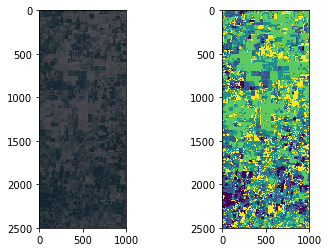

In [173]:
from matplotlib import pyplot as plt
f = plt.figure()
f.add_subplot(1, 2, 2)
r = bands_data[:,:,3]
g = bands_data[:,:,2]
b = bands_data[:,:,1]
rgb = np.dstack([r,g,b])
f.add_subplot(1, 2, 1)
plt.imshow(rgb/255)
f.add_subplot(1, 2, 2)
plt.imshow(classification)

In [175]:
with rasterio.open(
        'classified_image.tif', 'w',
        driver='GTiff',
        dtype=rasterio.uint8,
        count=1,
        width=src.width,
        height=src.height,
        transform=src.transform) as dst:
    dst.write(classification, indexes=1)